# Teacher–Student Distillation: An In-Depth Overview

Teacher–student distillation is a technique where a large, high-performance teacher model generates labels (or soft targets) for a dataset, and a smaller student model is then trained to mimic these predictions. The goal is to achieve competitive performance with a model that is much more efficient in terms of size and computational cost. In this project, we use the teacher model `cardiffnlp/twitter-roberta-base-sentiment-latest` to label IMDB movie reviews, and then fine-tune the student model `distilbert-base-uncased` for 10 epochs on this teacher-generated data.

---

## 1. Distillation Process Overview

- **Teacher Model:**  
  A robust model that classifies reviews into three categories: "negative", "neutral", and "positive".

- **Teacher Annotation:**  
  The teacher model is applied in batches (via `annotate_in_batches`), producing a CSV file with each review's text, its true binary label (from IMDB), and the teacher's sentiment prediction.

- **Student Model:**  
  A smaller model is fine-tuned on the teacher-annotated data so that it learns to mimic the teacher's output.

- **Evaluation:**  
  Both teacher and student outputs (3-class) are mapped to binary labels (0 for negative; 1 for neutral/positive) and compared with the original IMDB ground truth.

- **Visualization:**  
  Plots are created to compare accuracy and label distributions between the teacher and student.

---

## 2. How Distillation is Implemented in the Code

### A) Teacher Annotation

- **Function: `annotate_in_batches`**  
  - Processes the IMDB dataset in small batches.
  - For each batch, it extracts review texts and passes them to the teacher pipeline.
  - The teacher's predictions, along with the original text and true label, are written to a CSV file.
  - This CSV forms the training data for the student model.

### B) Preparing the Student Dataset

- The teacher-annotated CSV is loaded into a DataFrame.
- Textual labels ("negative", "neutral", "positive") are converted into numerical IDs using `label2id` and `id2label` dictionaries.
- The DataFrame is converted into a Hugging Face Dataset.
- The text data is tokenized using the student model’s tokenizer.
- Teacher-generated labels are renamed to “labels” for training.

### C) Training the Student Model

- **Model Initialization:**  
  The student model (`distilbert-base-uncased`) is set up for 3-class classification.

- **Training Setup:**  
  TrainingArguments (10 epochs, specific learning rate, batch size, and fp16 for mixed precision) and a custom metric (accuracy) are defined.

- **Trainer API:**  
  The Trainer fine-tunes the student model on the teacher-annotated dataset so it learns to replicate the teacher’s outputs.

### D) Evaluation and Visualization

- **Student Inference Pipeline:**  
  After training, a pipeline is created for the student to perform text classification.

- **Mapping Predictions:**  
  A helper function maps the student’s textual output to binary values (0 if "negative"; otherwise 1).

- **Accuracy Calculation:**  
  The binary predictions are compared against the IMDB ground truth to compute accuracy.

- **Visualization:**  
  - An accuracy bar chart compares teacher vs. student accuracy.
  - A side-by-side bar chart shows the distribution of sentiment predictions (negative, neutral, positive) for both models.

---

## 3. What is Teacher–Student Distillation?

Teacher–student distillation transfers knowledge from a large, complex teacher model to a smaller student model by training the student to mimic the teacher’s outputs. The key advantages are:

- **Efficiency:**  
  The student model is smaller and faster, ideal for resource-constrained environments.

- **Performance:**  
  A well-distilled student can approach the teacher’s accuracy.

- **Flexibility:**  
  This method can be applied across various tasks and model types.

In this project, the teacher’s predictions serve as additional supervision, enabling the student model to learn subtle patterns and nuances beyond the raw ground truth labels.

---

## 4. Conclusion

The code implements teacher–student distillation by first generating teacher annotations on a subset of the IMDB dataset and then fine-tuning a smaller student model on these annotations. This approach leverages the strong performance of the teacher to train a more efficient model, with evaluation and visualizations confirming the student’s learning effectiveness. This method is widely used for model compression, enabling deployment in environments with limited computational resources.

In [1]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score

In [2]:
##############################################################################
# 1. BATCH ANNOTATION FUNCTION
##############################################################################
def annotate_in_batches(ds, output_csv, teacher_pipeline, batch_size=16):
    """
    ds: a HuggingFace Dataset subset with ['text','label'] columns
    output_csv: file path to save the teacher-labeled CSV
    teacher_pipeline: pipeline(...) for sentiment (teacher)
    batch_size: how many samples to process at once
    """
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df = pd.DataFrame(ds)

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        fieldnames = ["text", "true_label", "teacher_label"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

        total_rows = len(df)
        start_idx = 0

        while start_idx < total_rows:
            end_idx = min(start_idx + batch_size, total_rows)
            batch = df.iloc[start_idx:end_idx]

            # Teacher pipeline on multiple texts
            results = teacher_pipeline(list(batch["text"]))

            for i, res in enumerate(results):
                writer.writerow({
                    "text": batch["text"].iloc[i],
                    "true_label": batch["label"].iloc[i],  # IMDB label (0=neg, 1=pos)
                    "teacher_label": res["label"]          # teacher's predicted sentiment ("negative","neutral","positive")
                })

            print(f"Annotated rows {start_idx} to {end_idx-1}")
            start_idx = end_idx

    print(f"\nDone! Teacher-labeled data saved to {output_csv}")

Train subset: 2000 rows
Test subset: 1000 rows
Sample train row: {'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered p

c:\Users\akshat-multimodel\anaconda3\envs\code\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequence

Annotated rows 0 to 15
Annotated rows 16 to 31
Annotated rows 32 to 47
Annotated rows 48 to 63
Annotated rows 64 to 79
Annotated rows 80 to 95
Annotated rows 96 to 111
Annotated rows 112 to 127
Annotated rows 128 to 143
Annotated rows 144 to 159


c:\Users\akshat-multimodel\anaconda3\envs\code\lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Annotated rows 160 to 175
Annotated rows 176 to 191
Annotated rows 192 to 207
Annotated rows 208 to 223
Annotated rows 224 to 239
Annotated rows 240 to 255
Annotated rows 256 to 271
Annotated rows 272 to 287
Annotated rows 288 to 303
Annotated rows 304 to 319
Annotated rows 320 to 335
Annotated rows 336 to 351
Annotated rows 352 to 367
Annotated rows 368 to 383
Annotated rows 384 to 399
Annotated rows 400 to 415
Annotated rows 416 to 431
Annotated rows 432 to 447
Annotated rows 448 to 463
Annotated rows 464 to 479
Annotated rows 480 to 495
Annotated rows 496 to 511
Annotated rows 512 to 527
Annotated rows 528 to 543
Annotated rows 544 to 559
Annotated rows 560 to 575
Annotated rows 576 to 591
Annotated rows 592 to 607
Annotated rows 608 to 623
Annotated rows 624 to 639
Annotated rows 640 to 655
Annotated rows 656 to 671
Annotated rows 672 to 687
Annotated rows 688 to 703
Annotated rows 704 to 719
Annotated rows 720 to 735
Annotated rows 736 to 751
Annotated rows 752 to 767
Annotated ro

c:\Users\akshat-multimodel\anaconda3\envs\code\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2500 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7913, 'learning_rate': 4.9e-05, 'epoch': 0.2}
{'loss': 0.784, 'learning_rate': 4.8020000000000004e-05, 'epoch': 0.4}
{'loss': 0.6821, 'learning_rate': 4.702e-05, 'epoch': 0.6}
{'loss': 0.6117, 'learning_rate': 4.602e-05, 'epoch': 0.8}
{'loss': 0.6445, 'learning_rate': 4.502e-05, 'epoch': 1.0}
{'loss': 0.5053, 'learning_rate': 4.4040000000000005e-05, 'epoch': 1.2}
{'loss': 0.4284, 'learning_rate': 4.306e-05, 'epoch': 1.4}
{'loss': 0.498, 'learning_rate': 4.206e-05, 'epoch': 1.6}
{'loss': 0.3392, 'learning_rate': 4.106e-05, 'epoch': 1.8}
{'loss': 0.3536, 'learning_rate': 4.0060000000000006e-05, 'epoch': 2.0}
{'loss': 0.2474, 'learning_rate': 3.906e-05, 'epoch': 2.2}
{'loss': 0.2064, 'learning_rate': 3.806e-05, 'epoch': 2.4}
{'loss': 0.2582, 'learning_rate': 3.7080000000000004e-05, 'epoch': 2.6}
{'loss': 0.2506, 'learning_rate': 3.608e-05, 'epoch': 2.8}
{'loss': 0.2659, 'learning_rate': 3.508e-05, 'epoch': 3.0}
{'loss': 0.0872, 'learning_rate': 3.408e-05, 'epoch': 3.2}
{'loss':

c:\Users\akshat-multimodel\anaconda3\envs\code\lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Student accuracy on test vs. real: 70.90%


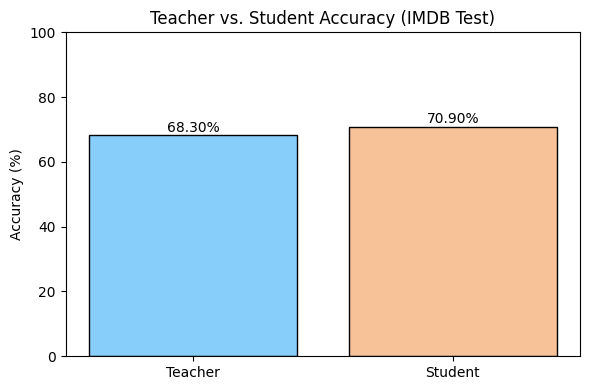

Accuracy chart saved to results/figures/teacher_vs_student_accuracy.png

Plotting label distribution on test set for teacher vs. student...


c:\Users\akshat-multimodel\anaconda3\envs\code\lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


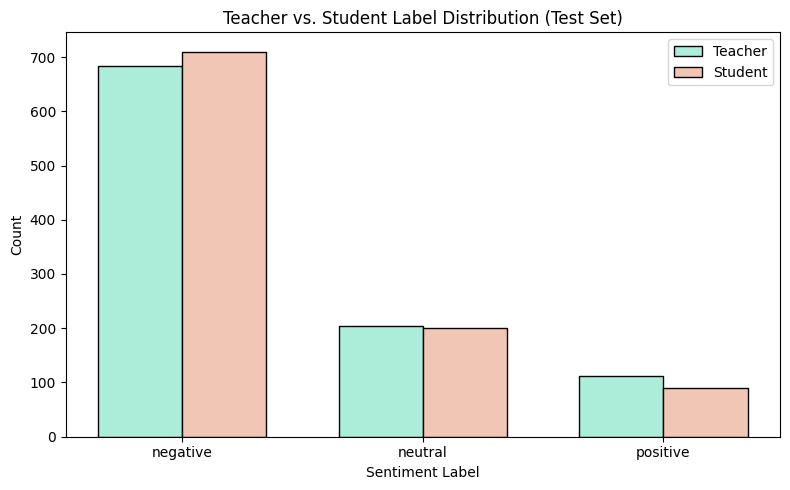

Label distribution chart saved to results/figures/teacher_vs_student_label_distribution.png

Done. Teacher vs. Student distillation + plots complete!


In [ ]:





##############################################################################
# 2. MAIN DISTILLATION LOGIC
##############################################################################
def main():
    ##############################################################################
    # A) LOAD LARGER SUBSET OF IMDB
    ##############################################################################
    # For demonstration, pick 2,000 training and 1,000 test examples.
    dataset = load_dataset("imdb")
    train_sub = dataset["train"].select(range(2000))
    test_sub  = dataset["test"].select(range(1000))

    print(f"Train subset: {len(train_sub)} rows")
    print(f"Test subset: {len(test_sub)} rows")
    print("Sample train row:", train_sub[0])

    ##############################################################################
    # B) TEACHER PIPELINE (3-CLASS)
    ##############################################################################
    teacher_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    teacher_pipeline_obj = pipeline(
        "sentiment-analysis",
        model=teacher_model_name,
        device=0,         # GPU if available
        batch_size=16,
        truncation=True,  # crucial for long reviews
        max_length=512,
        padding=True
    )

    ##############################################################################
    # C) ANNOTATE TRAIN/TEST WITH TEACHER
    ##############################################################################
    train_csv = "data/teacher_imdb_train.csv"
    test_csv  = "data/teacher_imdb_test.csv"

    if not os.path.exists(train_csv):
        annotate_in_batches(train_sub, train_csv, teacher_pipeline_obj, batch_size=16)
    if not os.path.exists(test_csv):
        annotate_in_batches(test_sub, test_csv, teacher_pipeline_obj, batch_size=16)

    df_train = pd.read_csv(train_csv)
    df_test  = pd.read_csv(test_csv)

    print("\nTeacher-labeled TRAIN sample:\n", df_train.head())

    ##############################################################################
    # D) TEACHER VS. REAL TEST ACCURACY
    ##############################################################################
    # IMDB is 0=neg,1=pos; teacher_label is negative,neutral,positive
    def teacher_label_to_int(lbl):
        # negative => 0, else => 1 (neutral or positive => 1)
        if lbl.lower() == "negative":
            return 0
        else:
            return 1

    teacher_preds_test = [teacher_label_to_int(x) for x in df_test["teacher_label"]]
    teacher_true_test  = list(df_test["true_label"])
    teacher_acc = accuracy_score(teacher_true_test, teacher_preds_test)
    print(f"Teacher accuracy on test (real labels): {teacher_acc*100:.2f}%")

    ##############################################################################
    # E) PREPARE STUDENT TRAIN DATA
    ##############################################################################
    label_list = ["negative","neutral","positive"]
    label2id   = {lbl: i for i, lbl in enumerate(label_list)}
    id2label   = {i: lbl for lbl, i in label2id.items()}

    # Filter out teacher_label not in [negative, neutral, positive]
    df_train = df_train[df_train["teacher_label"].isin(label2id.keys())].reset_index(drop=True)
    df_train["teacher_id"] = df_train["teacher_label"].apply(lambda x: label2id[x])

    train_dataset = Dataset.from_pandas(df_train)

    ##############################################################################
    # F) TOKENIZE FOR STUDENT (DISTILBERT)
    ##############################################################################
    student_model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(student_model_name)

    def tokenize_fn(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=256
        )

    train_dataset = train_dataset.map(tokenize_fn, batched=True)
    train_dataset = train_dataset.rename_column("teacher_id", "labels")
    train_dataset.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

    ##############################################################################
    # G) LOAD STUDENT MODEL & TRAINER
    ##############################################################################
    num_labels = len(label_list)  # 3
    student_model = AutoModelForSequenceClassification.from_pretrained(
        student_model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir="models/distilled_sentiment",
        evaluation_strategy="no",
        save_strategy="epoch",
        num_train_epochs=10,    # run 10 epochs as requested
        per_device_train_batch_size=8,
        learning_rate=5e-5,
        fp16=True,             # use mixed precision if GPU supports
        logging_steps=50,
        report_to="none"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        return {"accuracy": accuracy_score(labels, preds)}

    trainer = Trainer(
        model=student_model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    ##############################################################################
    # H) TRAIN (DISTILL)
    ##############################################################################
    trainer.train()

    ##############################################################################
    # I) EVALUATE STUDENT ON TEST VS. REAL
    ##############################################################################
    # Student pipeline returns textual labels: "negative","neutral","positive"
    student_pipeline = pipeline(
        "text-classification",
        model=trainer.model,
        tokenizer=tokenizer,
        device=0
    )

    def student_label_to_int(lbl):
        # If "negative" => 0, else => 1 (neutral or positive => 1)
        if lbl.lower() == "negative":
            return 0
        else:
            return 1

    # Inference on the entire test set (row by row)
    df_test["student_pred"] = df_test["text"].apply(
        lambda txt: student_label_to_int(
            student_pipeline(txt, truncation=True, max_length=256)[0]["label"]
        )
    )

    student_preds_test = df_test["student_pred"].tolist()
    student_true_test  = df_test["true_label"].tolist()
    student_acc = accuracy_score(student_true_test, student_preds_test)
    print(f"Student accuracy on test vs. real: {student_acc*100:.2f}%")

    ##############################################################################
    # J) PLOT 1: TEACHER VS. STUDENT ACCURACY
    ##############################################################################
    plt.figure(figsize=(6,4))
    models = ["Teacher","Student"]
    accs   = [teacher_acc*100, student_acc*100]
    bars = plt.bar(models, accs, color=["#87CEFA","#f7c297"], edgecolor="black")
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, h+1, f"{h:.2f}%", ha="center")

    plt.title("Teacher vs. Student Accuracy (IMDB Test)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.tight_layout()
    os.makedirs("results/figures", exist_ok=True)
    acc_fig = "results/figures/teacher_vs_student_accuracy.png"
    plt.savefig(acc_fig)
    plt.show()
    print(f"Accuracy chart saved to {acc_fig}")

    ##############################################################################
    # K) PLOT 2: TEACHER VS. STUDENT LABEL DISTRIBUTION
    ##############################################################################
    print("\nPlotting label distribution on test set for teacher vs. student...")

    # 1) Teacher distribution from df_test["teacher_label"]
    teacher_dist = df_test["teacher_label"].value_counts()

    # 2) Student distribution (full 3-class pass)
    # We'll gather negative/neutral/positive counts by re-running the pipeline
    # in batch to get textual labels
    def parse_student_label(lbl):
        # The pipeline returns "negative","neutral","positive"
        return lbl.lower()

    batch_size=32
    student_lbls_list = []
    for start_idx in range(0, len(df_test), batch_size):
        end_idx = min(start_idx+batch_size, len(df_test))
        texts = df_test["text"][start_idx:end_idx].tolist()
        outs = student_pipeline(texts, truncation=True, max_length=256)
        for out in outs:
            student_lbls_list.append(parse_student_label(out["label"]))

    # Count them
    student_series = pd.Series(student_lbls_list)
    student_dist = student_series.value_counts()

    # Combine
    # Ensure we have negative/neutral/positive (some might be missing from teacher)
    all_cats = ["negative","neutral","positive"]
    teacher_counts = [teacher_dist.get(cat,0) for cat in all_cats]
    student_counts = [student_dist.get(cat,0) for cat in all_cats]

    # Plot side-by-side
    x = range(len(all_cats))
    bar_width = 0.35

    plt.figure(figsize=(8,5))
    plt.bar([xx - bar_width/2 for xx in x], teacher_counts, width=bar_width,
            color="#abedd8", edgecolor="black", label="Teacher")
    plt.bar([xx + bar_width/2 for xx in x], student_counts, width=bar_width,
            color="#f2c6b4", edgecolor="black", label="Student")

    plt.xticks(x, all_cats)
    plt.title("Teacher vs. Student Label Distribution (Test Set)")
    plt.xlabel("Sentiment Label")
    plt.ylabel("Count")
    plt.legend()
    dist_fig = "results/figures/teacher_vs_student_label_distribution.png"
    plt.tight_layout()
    plt.savefig(dist_fig)
    plt.show()
    print(f"Label distribution chart saved to {dist_fig}")

    print("\nDone. Teacher vs. Student distillation + plots complete!")


if __name__ == "__main__":
    main()